In [1]:
# before runing, please update "Notebook File Root" to ${workspaceFolder}
# to make sure the following import works
import hydra
import torch
import os
from ucc.dataset import MNISTUCCTestDataset
from ucc.model import UCCModel
from omegaconf import DictConfig, OmegaConf
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
from ucc.visualize import visualize_distributions

device = torch.device("cuda" if torch.cuda.is_available() else "mps")

/opt/miniconda3/envs/torch1.13/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. setup and init
### 1.1 init config

In [2]:
with hydra.initialize(version_base=None, config_path="../configs"):
    cfg = hydra.compose(config_name="test.yaml")
print(OmegaConf.to_yaml(cfg))

args:
  model_path: saved_models/mnist_ucc_best.pth
  num_instances: 32
  ucc_start: 1
  ucc_end: 4
  batch_size: 20
  num_workers: 4
  num_bins: 11
  num_features: 10
  seed: 22
model:
  kde_model:
    num_bins: 11
    sigma: 0.1
  patch_model:
    conv_input_channel: 1
    conv_output_channel: 16
    block1_output_channel: 32
    block1_num_layer: 1
    block2_output_channel: 64
    block2_num_layer: 1
    block3_output_channel: 128
    block3_num_layer: 1
    flatten_size: 6272
    num_features: 10
  image_generation_model:
    linear_size: 6272
    reshape_size:
    - 128
    - 7
    - 7
    block1_output_channel: 128
    block1_num_layer: 1
    block2_output_channel: 64
    block2_num_layer: 1
    block3_output_channel: 32
    block3_num_layer: 1
    output_channel: 1
  classification_model:
    fc1_output_size: 384
    fc2_output_size: 192
    num_classes: 4



### 1.2 init model

In [3]:
def init_model(model_cfg, checkpoint_path, device):
    model = UCCModel(model_cfg)
    # load checkpoint
    ckpt = torch.load(checkpoint_path, map_location=torch.device("cpu"))
    state_dict = ckpt["model_state_dict"]
    msg = model.load_state_dict(state_dict)
    print("load ckpt msg: ", msg)
    model.to(device)
    return model

In [4]:
model = init_model(cfg.model, cfg.args.model_path, device)
print(model)

load ckpt msg:  <All keys matched successfully>
UCCModel(
  (patch_model): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): WideResidualBlocks(
      (blocks): Sequential(
        (0): ResidualZeroPaddingBlock(
          (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (skip_conv): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
        )
      )
    )
    (2): WideResidualBlocks(
      (blocks): Sequential(
        (0): ResidualZeroPaddingBlock(
          (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (skip_conv): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2))
        )
      )
    )
    (3): WideResidualBlocks(
      (blocks): Sequential(
        (0): ResidualZeroPaddingBlock(
          (conv1)

### 1.3 init dataloader

In [5]:
def init_dataloader(args):
    test_dataset = MNISTUCCTestDataset()
    test_loader = DataLoader(
        test_dataset,
        batch_size=args.batch_size,
        num_workers=args.num_workers,
        shuffle=False,
    )
    return test_loader

In [6]:
test_loader = init_dataloader(cfg.args)
print("data length: ",len(test_loader))

data length:  500


## 2. Reproduce Experiment Results
### 2.1 visualize feature distribution

In [7]:
from ucc.evaluate import extract_features, obtain_feature_dist_by_class
from ucc.visualize import (visualize_distributions, 
                           visualize_reconstucted_images, 
                           visualize_js_divergence)

100%|██████████| 500/500 [00:03<00:00, 152.32it/s]


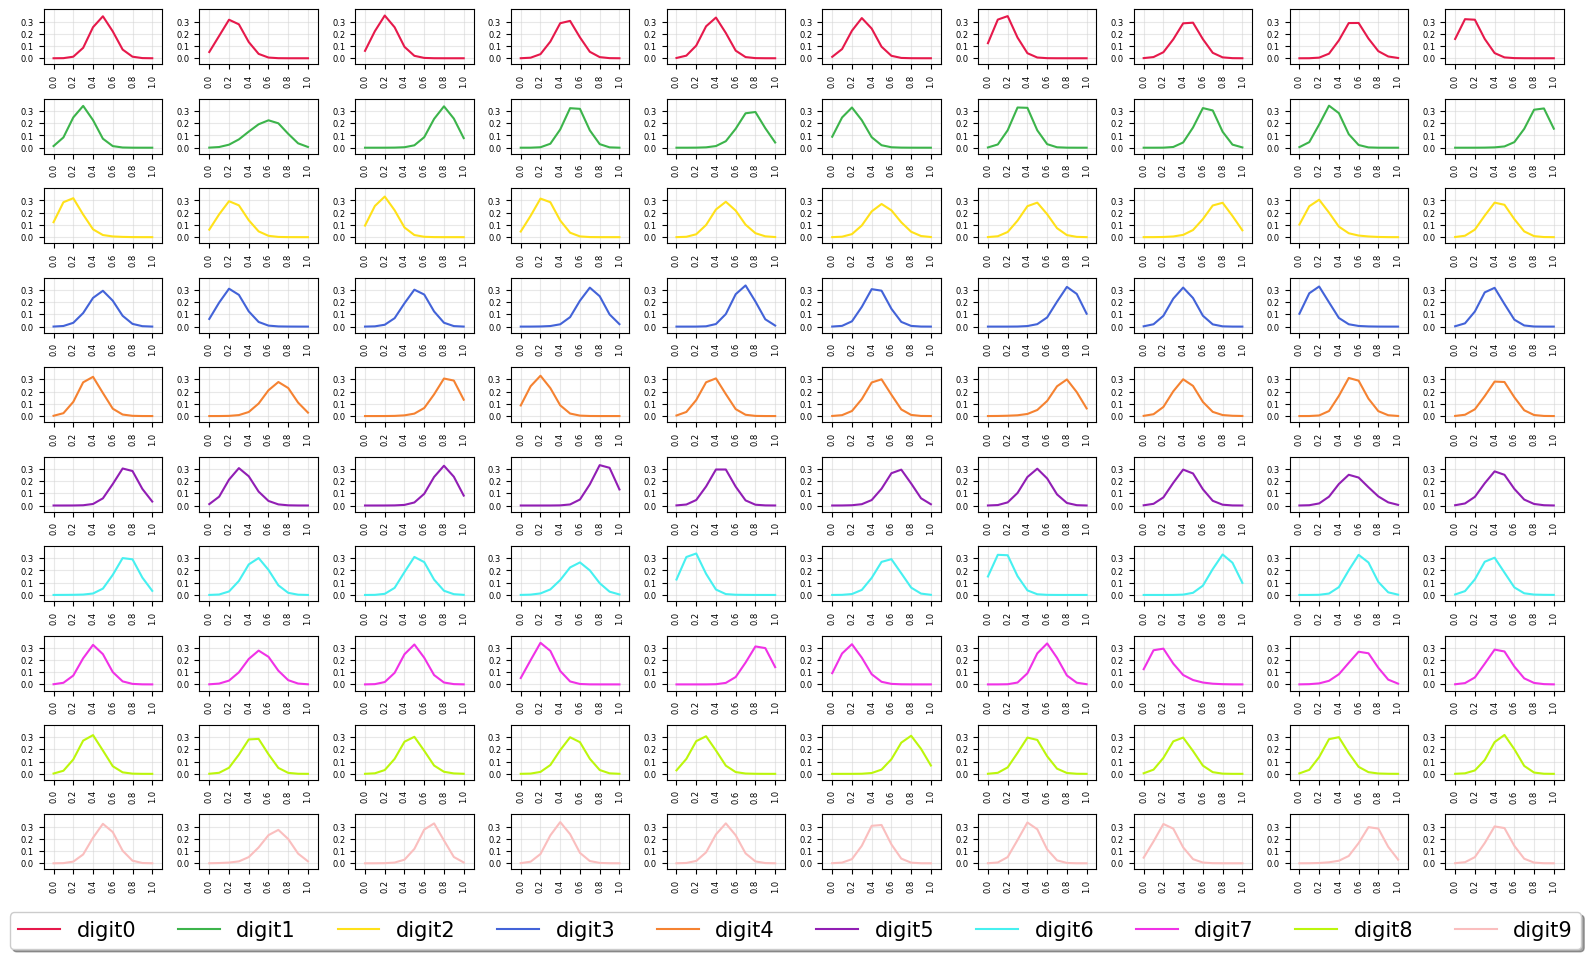

In [8]:
# extract features
features = extract_features(model, test_loader, device)
# obtain feature distribution by class
feature_dist_by_class = obtain_feature_dist_by_class(
    model, features, test_loader.dataset.y_test
)
# visualize
num_classes = len(feature_dist_by_class)
feature_distribution_arr = np.zeros(
    (num_classes, feature_dist_by_class[0].shape[1])
)
for c in feature_dist_by_class:
    feature_distribution_arr[c] = feature_dist_by_class[c].cpu().numpy()
classes = ["digit" + str(i) for i in range(num_classes)]
visualize_distributions(feature_distribution_arr, classes, model.num_bins)

### 2.2 reconstruct digit images

In [9]:
def obtain_mean_feature_by_class(features, labels):
    mean_feature_by_class = {}
    for feature, label in zip(features, labels):
        label = label.item()
        if label not in mean_feature_by_class:
            mean_feature_by_class[label] = []
        mean_feature_by_class[label].append(feature)
    # convert to tensor
    for label in mean_feature_by_class:
        mean_feature_by_class[label] = torch.stack(
            mean_feature_by_class[label], dim=0
        ).mean(dim=0)
    return mean_feature_by_class

reconstructed_imgs shape:  torch.Size([10, 1, 28, 28])


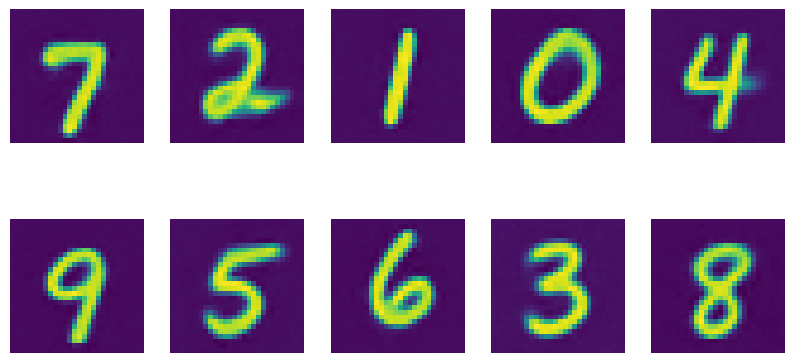

In [10]:
mean_feature_by_class = obtain_mean_feature_by_class(features, test_loader.dataset.y_test)
mean_feature_batch = torch.stack(list(mean_feature_by_class.values()), dim=0).to(device)
with torch.no_grad():
    reconstructed_imgs = model.generate_image_from_feature(mean_feature_batch)
print("reconstructed_imgs shape: ", reconstructed_imgs.shape)
reconstructed_imgs = reconstructed_imgs.cpu().numpy()
visualize_reconstucted_images(reconstructed_imgs)

### 2.3 calculate js divergence

In [11]:
def js_divergence(p,q):
	m = 0.5*(p+q)
	log_p_over_m = np.log2(p/m)
	log_q_over_m = np.log2(q/m)

	return 0.5*np.sum(p*log_p_over_m) + 0.5*np.sum(q*log_q_over_m)

JS divergence: min=0.22 - max=0.528 - mean=0.352 - std=0.134


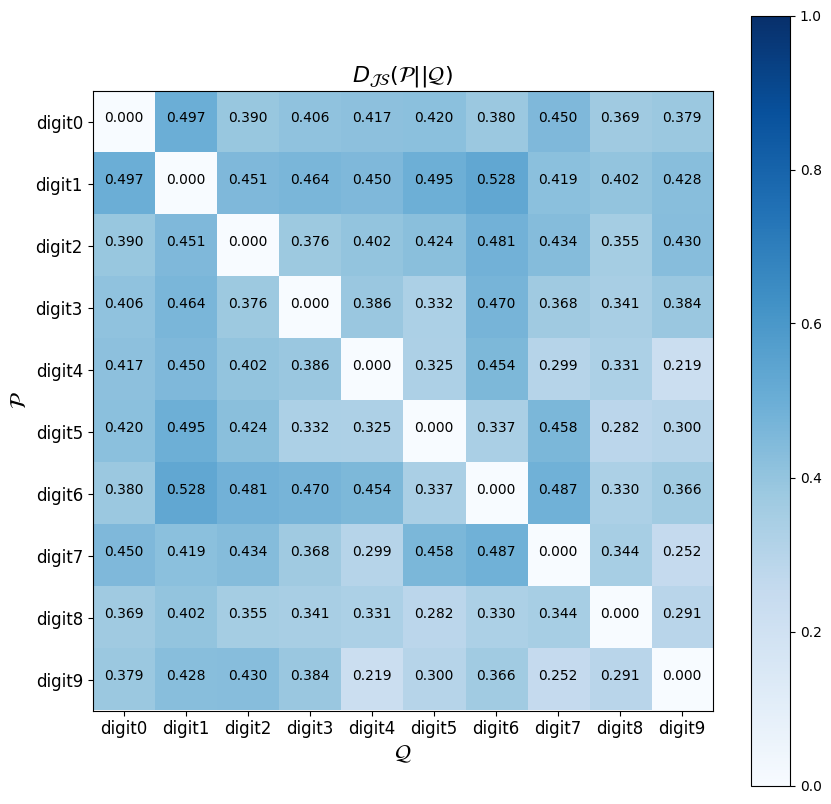

In [12]:
js_divergence_arr = np.zeros((10,10))
feature_distribution_norm = feature_distribution_arr / cfg.args.num_features
for i in range(10):
    p = np.clip(feature_distribution_norm[i,:], 1e-12, 1)
    for k in range(i, 10):
        q = np.clip(feature_distribution_norm[k,:], 1e-12, 1)
        js_divergence_arr[i,k] = js_divergence(p,q)
        js_divergence_arr[k,i] = js_divergence_arr[i,k]
print('JS divergence: min={:.2f} - max={:.3f} - mean={:.3f} - std={:.3f}'.format(
    np.amin(js_divergence_arr[js_divergence_arr>0]),np.amax(js_divergence_arr),np.mean(js_divergence_arr),np.std(js_divergence_arr)))
visualize_js_divergence(js_divergence_arr, classes)

### 2.4 clustering

In [34]:
from time import time
from sklearn import metrics
from sklearn.cluster import KMeans, SpectralClustering
from prettytable import PrettyTable
from scipy.optimize import linear_sum_assignment

#### 2.4.1 eval clustering by metrics

In [27]:
def eval_clustering(estimator=None, name=None, data=None, labels=None):
	t0 = time()
	estimator.fit(data)
	homogeneity_score = metrics.homogeneity_score(labels, estimator.labels_)
	completeness_score = metrics.completeness_score(labels, estimator.labels_)
	v_measure_score = metrics.v_measure_score(labels, estimator.labels_)
	adjusted_rand_score = metrics.adjusted_rand_score(labels, estimator.labels_)
	adjusted_mutual_info_score = metrics.adjusted_mutual_info_score(labels,  estimator.labels_)

	table = PrettyTable()
	table.field_names = ["init", "time", "homo", "compl", "v-meas", "ARI", "AMI"]
	table.add_row([name, round((time() - t0), 2), 
		round(homogeneity_score, 3), 
		round(completeness_score, 3), 
		round(v_measure_score, 3), 
		round(adjusted_rand_score, 3), 
		round(adjusted_mutual_info_score, 3)])
	print(table)

	clustering_scores = np.array([homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score, adjusted_mutual_info_score]).reshape((1,-1))
	return clustering_scores

In [28]:
# cluster all data
num_clusters = len(classes)
estimator = SpectralClustering(n_clusters=num_clusters, eigen_solver='arpack', affinity="nearest_neighbors")
spectral_clustering_scores = eval_clustering(estimator=estimator, name='all: spectral-nn', data=features, labels=test_loader.dataset.y_test)

estimator = KMeans(n_clusters=num_clusters, init='k-means++', n_init=10)
kmeans_clustering_scores = eval_clustering(estimator=estimator, name='all: kmeans++', data=features, labels=test_loader.dataset.y_test)

+------------------+------+-------+-------+--------+-------+-------+
|       init       | time |  homo | compl | v-meas |  ARI  |  AMI  |
+------------------+------+-------+-------+--------+-------+-------+
| all: spectral-nn | 2.27 | 0.954 | 0.954 | 0.954  | 0.962 | 0.954 |
+------------------+------+-------+-------+--------+-------+-------+
+---------------+------+-------+-------+--------+-------+-------+
|      init     | time |  homo | compl | v-meas |  ARI  |  AMI  |
+---------------+------+-------+-------+--------+-------+-------+
| all: kmeans++ | 0.27 | 0.945 | 0.946 | 0.946  | 0.953 | 0.945 |
+---------------+------+-------+-------+--------+-------+-------+


#### 2.4.2 obtain clustering labels

In [29]:
def predict_cluster_labels(estimator=None, data=None):
	estimator.fit(data)
	predicted_clustering_labels = estimator.labels_

	return predicted_clustering_labels

In [30]:
nn_estimator = SpectralClustering(n_clusters=num_clusters, eigen_solver='arpack', affinity="nearest_neighbors")
kmeans_estimator = KMeans(n_clusters=num_clusters, init='k-means++', n_init=10)

nn_predicted_labels = predict_cluster_labels(estimator=nn_estimator, data=features)
kmeans_predicted_labels = predict_cluster_labels(estimator=kmeans_estimator, data=features)

#### 2.4.3 calculate clustering accuracy
Due to the label predicted by the clustering method is not aligned with original labels, we have to use linear sum assignment to determine the right label

In [44]:
def compute_clustering_accuracy(truth_labels_arr, predicted_labels_arr):	
    cost_matrix = np.zeros((10,10))
    num_samples = np.zeros(10)
    for truth_val in range(10):
        temp_sample_indices = np.where(truth_labels_arr == truth_val)[0]
        num_samples[truth_val] = temp_sample_indices.shape[0]

        temp_predicted_labels = predicted_labels_arr[temp_sample_indices]

        for predicted_val in range(10):

            temp_matching_pairs = np.where(temp_predicted_labels == predicted_val)[0]

            cost_matrix[truth_val,predicted_val] = 1- (temp_matching_pairs.shape[0]/temp_sample_indices.shape[0])

    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    cost = cost_matrix[row_ind,col_ind]

    clustering_acc = ((1-cost)*num_samples).sum() / num_samples.sum()
    return clustering_acc

In [45]:
nn_cluster_acc = compute_clustering_accuracy(
    test_loader.dataset.y_test, nn_predicted_labels)
kmeans_cluster_acc = compute_clustering_accuracy(
    test_loader.dataset.y_test, kmeans_predicted_labels)
print('nn_cluster_acc: {:.3f} - kmeans_cluster_acc: {:.3f}'.format(nn_cluster_acc, kmeans_cluster_acc))

nn_cluster_acc: 0.983 - kmeans_cluster_acc: 0.979
